I weant to test a few ideas about motion correciton on different animals and somehow evaluate the effects and determine which one to adopt.

- Methods
    1. Old method: lowpass filtering > linear regression > subtraction > dF/F > zscore
    2. bandpass filtering to flatten data >  linear regression > subtraction > dF/F > zscore
    3. bandpass filtering to flatten data >  PLS  regression > subtraction > dF/F > zscore
    4 ????

- Evalutation methods
    1. Eyeballing the overlaid two curves (signal and estimated motion artefacts)
    2. Scatter plot
    3. Correlation coefficient
    4. cross-correlation and peak at T = 0
    5. Sum of absolute difference per unit time???
    6. VAR



In [36]:
import os

nb_name = "nb20230505_091600_eval_motion_correction.ipynb" #TODO change this

basename, ext = os.path.splitext(nb_name)
input_path = os.path.join(os.getcwd(), nb_name)

!jupyter nbconvert "{input_path}" --to="python" --output="{basename}"

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook d:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230505_091600_eval_motion_correction.ipynb to python
[NbConvertApp] Writing 29717 bytes to d:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230505_091600_eval_motion_correction.py


# 1. Specify target sessions

debug_folders: list of folder paths

In [2]:

dir_by_sessions = r"\\ettin\Magill_lab\Julien\Data\head-fixed\by_sessions"

def join_task_session(taskname, sessionnames: list):
    return [os.path.join(dir_by_sessions, taskname, ssn) for ssn in sessionnames]

task1 = join_task_session('reaching_go_spout_bar_nov22', [
    'kms058-2023-03-24-151254',
    'kms058-2023-03-25-184034',
    'kms062-2023-02-21-103400',
    'kms062-2023-02-22-150828',
    'kms063-2023-04-09-183115',
    'kms063-2023-04-10-194331',
    'kms064-2023-02-13-104949',
    'kms064-2023-02-15-104438',
    'kms064-2023-02-16-103424',
    'RE602-2023-03-22-121414'])

task2 = join_task_session('reaching_go_spout_bar_dual_dec22', [
    'JC316L-2022-12-07-163252',
    'JC316L-2022-12-08-143046'])


debug_folders = task1 + task2


# Prep data

In [3]:
import pandas as pd
from trialexp.process.pycontrol.utils import export_session
from snakehelper.SnakeIOHelper import getSnake
# from workflow.scripts import settings
from re import match
from pathlib import Path
from trialexp.process.pyphotometry.utils import *

class sinput_class():
    def __init__(self):
        self.photometry_folder = None
        self.pycontrol_dataframe = None
        self.pycontrol_folder = None

def load_and_prep_photom(debug_folder):
    # (sinput, soutput) = getSnake(locals(), 'workflow/pycontrol.smk',
    #                             os.path.join(debug_folder, '/processed/spike2.smrx'),
    #                             'export_spike2')
    sinput = sinput_class()
    sinput.photometry_folder = os.path.join(debug_folder,'pyphotometry')
    sinput.pycontrol_dataframe = os.path.join(debug_folder,'processed','df_pycontrol.pkl')
    sinput.pycontrol_folder = os.path.join(debug_folder,'pycontrol')

    # %% Photometry dict

    # fn = glob(sinput.photometry_folder+'\*.ppd')[0]
    fn = list(Path(sinput.photometry_folder).glob('*.ppd'))
    if fn == []:
        data_photometry = None
    else:
        fn = fn[0]
        data_photometry = import_ppd(fn)

        data_photometry = denoise_filter(data_photometry)
        data_photometry = motion_correction(data_photometry)
        data_photometry = compute_df_over_f(data_photometry, low_pass_cutoff=0.001)


    # no down-sampling here

    # %% Load data
    df_pycontrol = pd.read_pickle(sinput.pycontrol_dataframe)

    pycontrol_time = df_pycontrol[df_pycontrol.name == 'rsync'].time

    # assuming just one txt file
    pycontrol_txt = list(Path(sinput.pycontrol_folder).glob('*.txt'))

    with open(pycontrol_txt[0], 'r') as f:
        all_lines = [line.strip() for line in f.readlines() if line.strip()]

    count = 0
    print_lines = []
    while count < len(all_lines):
        # all_lines[count][0] == 'P'
        if bool(match('P\s\d+\s', all_lines[count])):
            print_lines.append(all_lines[count][2:])
            count += 1
            while (count < len(all_lines)) and not (bool(match('[PVD]\s\d+\s', all_lines[count]))):
                print_lines[-1] = print_lines[-1] + \
                    "\n" + all_lines[count]
                count += 1
        else:
            count += 1

    v_lines = [line[2:] for line in all_lines if line[0] == 'V']


    # %%
    if fn == []:
        photometry_times_pyc = None
    else:
        photometry_aligner = Rsync_aligner(
            pycontrol_time, data_photometry['pulse_times_2'])
        photometry_times_pyc = photometry_aligner.B_to_A(data_photometry['time'])

    # remove all state change event
    df_pycontrol = df_pycontrol.dropna(subset='name')
    df2plot = df_pycontrol[df_pycontrol.type == 'event']
    # state is handled separately with export_state, whereas parameters are handled vchange_to_text

    keys = df2plot.name.unique()

    photometry_keys = ['analog_1', 'analog_2',  'analog_1_filt', 'analog_2_filt',
                    'analog_1_est_motion', 'analog_1_corrected', 'analog_1_baseline_fluo',
                    'analog_1_df_over_f']

    return df_pycontrol, pycontrol_time, data_photometry, photometry_times_pyc, photometry_keys

# export_session(df_pycontrol, keys, 
#     data_photometry = data_photometry,
#     photometry_times_pyc = photometry_times_pyc,
#     photometry_keys = photometry_keys,
#     print_lines = print_lines,
#     v_lines = v_lines,
#     smrx_filename=soutput.spike2_file)

In [4]:
data_list = []

for d in debug_folders:
    data_dict = dict(df_pycontrol=None, pycontrol_time=None, data_photometry=None, photometry_times_pyc=None, photometry_keys = None, debug_folder=None)
    data_dict['df_pycontrol'], data_dict['pycontrol_time'], data_dict['data_photometry'], \
        data_dict['photometry_times_pyc'], data_dict['photometry_keys'] = load_and_prep_photom(d)
    data_dict['debug_folder'] = d
    data_list.append(data_dict)
df_data = pd.DataFrame(data_list)

df_data['subject_ID'] = [r['subject_ID'] if r is not None else None for r in df_data['data_photometry']]
df_data['date_time'] = [r['date_time']
                        if r is not None else None for r in df_data['data_photometry']]


# Processing and evaluation

cf. 

```
process/pyphotometry/utils.py/motion_corretion()
```

- Correlation Coefficients and scatter plots
- Cross-correlation and measuring the peak at 0

In [5]:
df_data.columns

Index(['df_pycontrol', 'pycontrol_time', 'data_photometry',
       'photometry_times_pyc', 'photometry_keys', 'debug_folder', 'subject_ID',
       'date_time'],
      dtype='object')

In [6]:
df_data['subject_ID']

0     kms058
1     kms058
2     kms062
3     kms062
4     kms063
5     kms063
6     kms064
7     kms064
8     kms064
9      RE602
10      None
11      None
Name: subject_ID, dtype: object

In [7]:
df_data.iloc[0, 0].columns

Index(['type', 'name', 'time', 'duration', 'value'], dtype='object')

In [8]:
df_data.iloc[0,1]


20            0.0
24         1230.0
36         2617.0
45         9722.0
49        14945.0
          ...    
8778    3578833.0
8788    3587981.0
8793    3593159.0
8797    3595914.0
8798    3597043.0
Name: time, Length: 713, dtype: float64

In [9]:
# nan_indices = np.argwhere(np.isnan(photometry_times_pyc))
# T_nonan = np.delete(photometry_times_pyc, nan_indices)
# max_time_ms = T_nonan[-1]


def get_newTandY_orig(T, photometry_dict, name, max_time_ms, photometry_times_pyc):
    nan_indices = np.argwhere(np.isnan(photometry_times_pyc))
    T_nonan = np.delete(photometry_times_pyc, nan_indices)
    max_time_ms = T_nonan[-1]


    T = photometry_times_pyc  # not down-sampled yet

    nan_indices = np.argwhere(np.isnan(T))
    T_nonan = np.delete(T, nan_indices)

    Y = photometry_dict[name]
    Y_nonan = np.delete(Y, nan_indices)  # []
    max_time_ms = T_nonan[-1]

    # NOTE sampling_rate was originally 1000
    new_T = np.arange(0, max_time_ms, 1/1000*1000)
    new_Y = np.interp(new_T, T_nonan, Y_nonan)
    return new_T, new_Y


def get_newTandY_down(T, photometry_dict, name, max_time_ms, photometry_times_pyc):
    nan_indices = np.argwhere(np.isnan(photometry_times_pyc))
    T_nonan = np.delete(photometry_times_pyc, nan_indices)
    max_time_ms = T_nonan[-1]

    Tdown = [T[i] for i in range(0, len(T), 10)]  # down sampled time vector

    nan_indices = np.argwhere(np.isnan(Tdown))
    Tdown_nonan = np.delete(Tdown, nan_indices)

    Y = photometry_dict[name]
    Y_nonan = np.delete(Y, nan_indices)  # []

    # Need to use interp to accomodate data into Spike2 bins
    # NOTE sampling_rate is already downsampled by 10
    new_T = np.arange(0, max_time_ms, 1/photometry_dict['sampling_rate']*1000)
    new_Y = np.interp(new_T, Tdown_nonan, Y_nonan)
    return new_T, new_Y


In [10]:

[print(k) for k in df_data.loc[0,'data_photometry'].keys()]


analog_1
analog_2
digital_1
digital_2
pulse_inds_1
pulse_inds_2
pulse_times_1
pulse_times_2
time
subject_ID
date_time
mode
sampling_rate
volts_per_division
LED_current
version
analog_1_filt
analog_2_filt
analog_1_est_motion
analog_1_corrected
motion_corrected
analog_1_baseline_fluo
analog_1_df_over_f


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [11]:
lowpass_freq = 20
highpass_freq = 0.001  # 10 s cycle
sampling_rate = 1000

# trialexp\process\pyphotometry\utils.py
# see https://vscode.dev/github/juliencarponcy/trialexp/blob/fd1e0dcc857275cafa7f809a104fd60e73ce1458/trialexp/process/pyphotometry/utils.py#L51
b, a = get_filt_coefs(low_pass=lowpass_freq,
                      high_pass=highpass_freq,
                      sampling_rate=sampling_rate)
analog_1_bp = filtfilt(b, a, df_data.loc[0,'data_photometry']['analog_1'], padtype='even')
analog_2_bp = filtfilt(b, a, df_data.loc[0,'data_photometry']['analog_2'], padtype='even')



GTP-4

> In the context of digital filters, the roots of the polynomial represented by the filter coefficients are very important, because they determine the behavior of the filter. Specifically, the roots of the 'a' coefficients (which form the denominator of the filter's transfer function) are called the "**poles**" of the filter. The locations of these poles in the complex plane determine whether the filter is stable or not.

> If all poles are inside the unit circle (meaning their absolute value is less than 1), then the filter is stable. If any pole is outside the unit circle, then the filter is unstable. This is why we use `numpy.roots(a)` and `numpy.abs()` to check the stability of the filter.

In [12]:

def check_stability(b, a):
    """Check the stability of a digital filter."""
    # Get the poles of the filter
    poles = np.roots(a)

    # Check if all poles are inside the unit circle
    return np.all(np.abs(poles) < 1)


is_stable = check_stability(b, a)
print(f"The filter is {'stable' if is_stable else 'unstable'}.")


The filter is stable.


https://vscode.dev/github.com/juliencarponcy/trialexp/blob/fd1e0dcc857275cafa7f809a104fd60e73ce1458/trialexp/process/pyphotometry/utils.py#L51
https://github.com/juliencarponcy/trialexp/blob/fd1e0dcc857275cafa7f809a104fd60e73ce1458/trialexp/process/pyphotometry/utils.py#L51-L52

In [13]:
b,a = get_filt_coefs(low_pass=20, sampling_rate=sampling_rate) # from pipeline

is_stable = check_stability(b, a)
print(f"The filter is {'stable' if is_stable else 'unstable'}.")


The filter is stable.


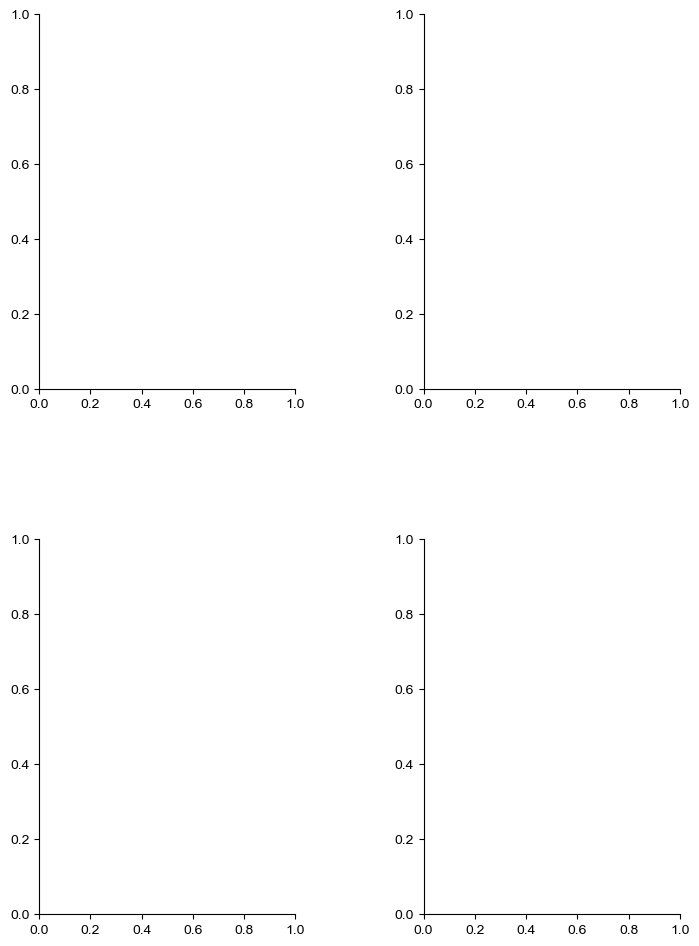

In [14]:
# %matplotlib widget
# %matplotlib notebook # not working

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = ['Arial']

plt.close()
plt.interactive(True)

cm = 1/2.54  # centimeters in inches
A4 = (21*cm, 29.7*cm)

fig, ax = plt.subplots(2,2, figsize=A4)
for i in range(ax.shape[0]):
    for j in range((ax.shape[1])):
        plt.tick_params(direction='out')
    

fig.subplots_adjust(hspace=0.4, wspace=0.5)


In [15]:
i = 0
j = 0
plt.sca(ax[0, 0])
ax[i,j].spines['top'].set_visible(False)
ax[i,j].spines['right'].set_visible(False)

analog_1_filt = df_data.loc[0,'data_photometry']['analog_1']
analog_2_filt = df_data.loc[0,'data_photometry']['analog_2']

analog_1_est_motion = df_data.loc[0,'data_photometry']['analog_1_est_motion']
analog_1_corrected = df_data.loc[0,'data_photometry']['analog_1_corrected']
analog_1_df_over_f = df_data.loc[0, 'data_photometry']['analog_1_est_motion']


plt.plot(analog_2_filt, analog_1_filt, '+', color=(0.5,0.5,0.5), markersize=2, zorder=1)

# Calculate the 2D histogram
hist, x_edges, y_edges = np.histogram2d(analog_2_filt, analog_1_filt, bins=30)

# Calculate the bin centers from the bin edges
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Create a meshgrid of bin centers
X, Y = np.meshgrid(x_centers, y_centers)

# Create the custom colormap

log_norm = mcolors.LogNorm(vmin=1e-10, vmax=None)

# Plot the contour plot
#plt.contourf(X, Y, hist.T, cmap=custom_cmap, norm=norm)
cnt = plt.contourf(X, Y, hist.T, cmap='viridis', norm=log_norm, zorder=2)


df_data.loc[0,'data_photometry']['analog_1']
plt.xlabel('analog_2_filt, red')
plt.ylabel('analog_1_filt, green')

plt.colorbar(cnt, location='top')

ax[i,j].set_title('Lowpass filtering only', y = 1.25)

# linregress
slope, intercept, r_value, p_value, std_err = linregress(
    x=analog_2_filt, y=analog_1_filt)

x0 = np.arange(np.min(analog_2_filt), np.max(analog_2_filt), 
               (np.max(analog_2_filt) - np.min(analog_2_filt))/1000)
y0 = slope*x0 + intercept

plt.plot(x0, y0, '-', color='red', linewidth=2, zorder=3)

plt.text(0.5,0.9,f'$R^2=${r_value**2:.3f}', transform=plt.gca().transAxes, ha='left')



C:\Users\phar0528\AppData\Local\Temp\ipykernel_50672\3918988155.py:33: UserWarning: Log scale: values of z <= 0 have been masked
  cnt = plt.contourf(X, Y, hist.T, cmap='viridis', norm=log_norm, zorder=2)


Text(0.5, 0.9, '$R^2=$0.501')

In [16]:
print(f'{max(analog_2_filt)}, {min(analog_2_filt)}')
print(f'{max(analog_1_filt)}, {min(analog_1_filt)}')


0.9975231, 0.53535258
0.54162822, 0.12379206


In [17]:
# bandpath filtering followed by linear regression

i = 0
j = 1
plt.sca(ax[i, j])
ax[i,j].spines['top'].set_visible(False)
ax[i,j].spines['right'].set_visible(False)

plt.plot(analog_2_bp, analog_1_bp, '+', color=(0.5,0.5,0.5),markersize=2, zorder=1)

# Calculate the 2D histogram
hist, x_edges, y_edges = np.histogram2d(analog_2_bp, analog_1_bp, bins=30)

# Calculate the bin centers from the bin edges
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Create a meshgrid of bin centers
X, Y = np.meshgrid(x_centers, y_centers)

# Create the custom colormap

log_norm = mcolors.LogNorm(vmin=1e-10, vmax=None)

# Plot the contour plot
#plt.contourf(X, Y, hist.T, cmap=custom_cmap, norm=norm)
cnt = plt.contourf(X, Y, hist.T, cmap='viridis', norm=log_norm, zorder=2)


df_data.loc[0,'data_photometry']['analog_1']
plt.xlabel('analog_2_bp, red')
plt.ylabel('analog_1_bp, green')

cb1= plt.colorbar(cnt, location='top')

ax[i,j].set_title('Bandpass filtering', y = 1.25)

# linregress
slope, intercept, r_value, p_value, std_err = linregress(
    x=analog_2_bp, y=analog_1_bp)

x0 = np.arange(np.min(analog_2_bp), np.max(analog_2_bp), 
               (np.max(analog_2_bp) - np.min(analog_2_bp))/1000)
y0 = slope*x0 + intercept

plt.plot(x0, y0, '-', color='red', linewidth=2, zorder=3)

analog_1_est_motion_bp = slope * analog_2_bp + intercept

plt.text(0.5, 0.9, f'$R^2$={r_value**2:.2f}',
         transform=plt.gca().transAxes, ha='left')


C:\Users\phar0528\AppData\Local\Temp\ipykernel_50672\2490800832.py:27: UserWarning: Log scale: values of z <= 0 have been masked
  cnt = plt.contourf(X, Y, hist.T, cmap='viridis', norm=log_norm, zorder=2)


Text(0.5, 0.9, '$R^2$=0.17')

In [18]:
# bandpath filtering followed by PLS regression
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
# T = photometry_times_pyc # not down-sampled yet
# nan_indices = np.argwhere(np.isnan(T))

# X = photometry_dict['analog_2_filt'].reshape(-1, 1)
# X = np.delete(X, nan_indices)
# X = X.reshape(-1, 1)

# y = photometry_dict['analog_1_filt'].reshape(-1, 1)
# y = np.delete(y, nan_indices)
# y = y.reshape(-1, 1)


# split the data to training and test
X_train, X_test, y_train, y_test = train_test_split(
    analog_2_bp.reshape(-1, 1), analog_1_bp.reshape(-1, 1), test_size=0.2, random_state=42)

# PLS regression model creation and learning
pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

# model prediction and evaluation
y_pred = pls.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean squared error: {mse:.2f}')
print(f'R2 score: {r2:.2f}')

plt.text(0.5,0.84,f'PLS $R^2=${r2:.2f}', transform=plt.gca().transAxes, ha='left')
plt.text(0.5,0.78,f'PLS $MSE$={mse:.2f}', transform=plt.gca().transAxes, ha='left')

plt.plot(X_test, y_pred, ':', color='yellow', linewidth=2)


Mean squared error: 0.00
R2 score: 0.17


PLS result is virtually identical to linear regression.

Not worth!

GTP-4

> If you ran `linregress()` and `PLSRegression(n_components=1)` on the same dataset and obtained virtually identical results, it suggests that a linear relationship between the predictor variables and the response variable is sufficient to explain the variation in the data, and that the relationship is not highly nonlinear or complex.

> `linregress()` performs a simple linear regression analysis that fits a straight line to the data, while `PLSRegression(n_components=1)` performs a partial least squares regression analysis that projects the data onto a lower-dimensional space to capture the linear relationship between the variables.

> When `n_components=1` is used in `PLSRegression()`, the model will use only one latent variable to model the relationship between the predictor variables and the response variable. This means that the model will have a low level of complexity and may underfit the data if the relationship between the variables is more complex. However, if the data exhibits a linear relationship, then using only one latent variable can be a good starting point to explore the relationship between the variables and identify the most important features.

>L In summary, if `linregress()` and `PLSRegression(n_components=1)` yield similar results, it suggests that a linear relationship between the predictor variables and the response variable is sufficient to explain the variation in the data. However, it is always a good idea to check the assumptions of the regression models and to evaluate the performance of the models using appropriate metrics such as R-squared, mean squared error, etc., before drawing conclusions about the relationship between the variables. Additionally, you may want to experiment with different values of `n_components` in `PLSRegression()` to find the optimal level of complexity for your data.

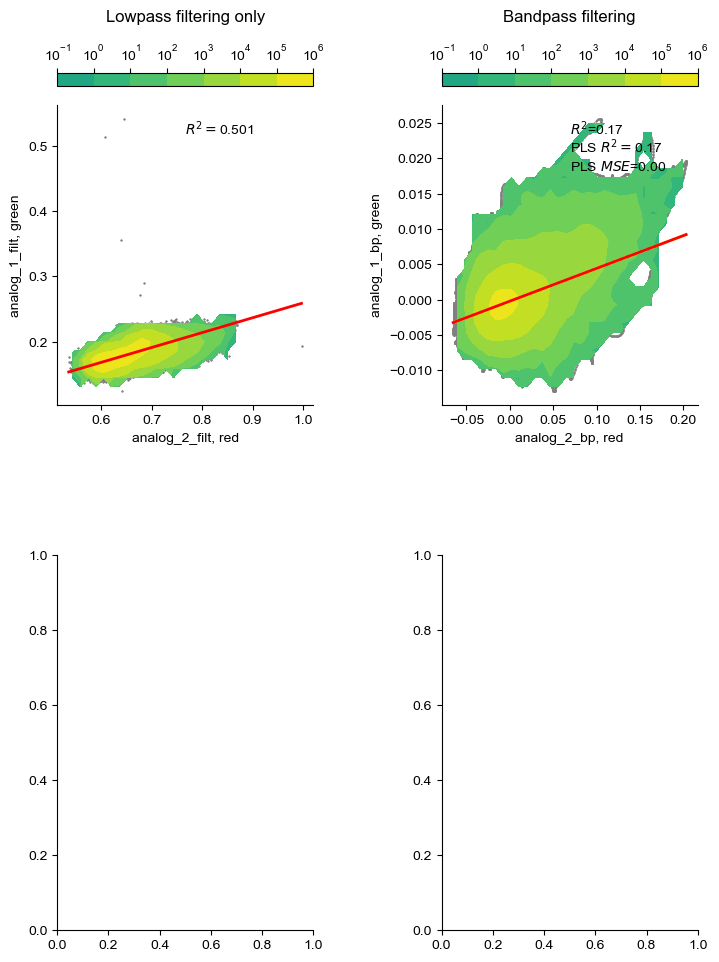

In [19]:
plt.show()

# Cross-correlation

Without specific triggers for motion artefacts, this mey be the best option.


Cross-corrleatino between
- filtered and filtered

Looked like a mountain shape with two straight line.
No periodicity and linear decline in correlation in relation to the distance from time 0.

- filtered and motion estimates
- filtered and motion estimates


In [20]:

# xcorr

import numpy as np
import scipy.signal

# Example time series data A and B

# Compute the cross-correlation between A and B
cross_correlation = scipy.signal.correlate(analog_1_filt, analog_2_filt, mode='full', method='fft')


#TODO need to handle time vector (the use interploation to get uniform interval) or Fs (if I can assume uniform sampling)



In [21]:

# Calculate the lags
full_lags = np.arange(-len(analog_1_filt) +1, len(analog_2_filt) ) 
full_lags = [l * 1/1000 for l in full_lags] # in seconds

# min_lag_ms = -3000
# max_lag_ms = 3000

# selected_indices = (full_lags >= min_lag) & (full_lags <= max_lag)
# selected_lags = full_lags[selected_indices]
# selected_cross_correlation = cross_correlation[selected_indices]


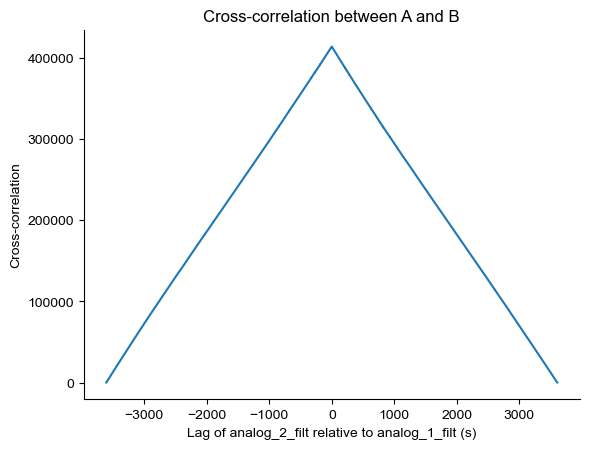

In [22]:
# Plot the cross-correlation
plt.plot(full_lags, cross_correlation)
plt.xlabel('Lag of analog_2_filt relative to analog_1_filt (s)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between A and B')

plt.show()

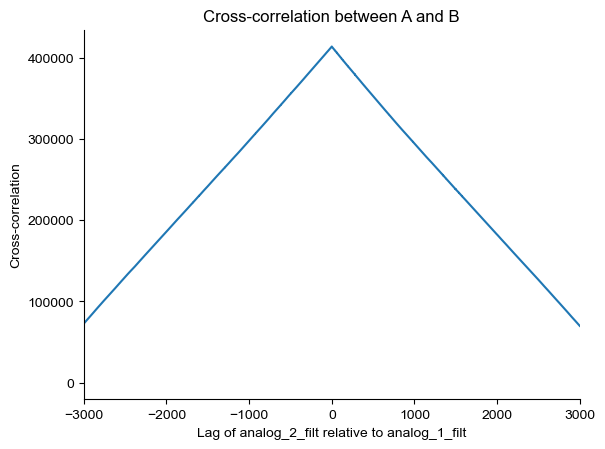

In [23]:

# Plot the cross-correlation
plt.plot(full_lags, cross_correlation)
plt.xlabel('Lag of analog_2_filt relative to analog_1_filt')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between A and B')

plt.xlim(-3*1000, 3*1000) # -3 s to + 3 s for 1 kHz data 

plt.show()

# very odd result


# Triggered average anaylsis

Also, we can set a threshold on z-score (eg. 1, 1,5 or 2) to find motion artifact onset and use that as a trigger.


In [24]:
# How to get the time vector?

photometry_times_pyc = df_data.loc[0,'photometry_times_pyc']


In [25]:

mn = np.mean(analog_2_bp)
sd = np.std(analog_2_bp)

ind = np.where(np.abs(analog_2_bp - mn) > 2 * sd)[0]
diffs = np.diff(ind)
non_consecutive_positions = np.where(diffs != 1)[0]

preceded_by_interval = positions = np.where(diffs > 3000)[0] # preceded by 3 s intervals

ind_ = np.array(sorted(list(set(non_consecutive_positions) & set(preceded_by_interval))))

trig_ind = ind[ind_ + 1]

trig_ms = photometry_times_pyc[trig_ind]


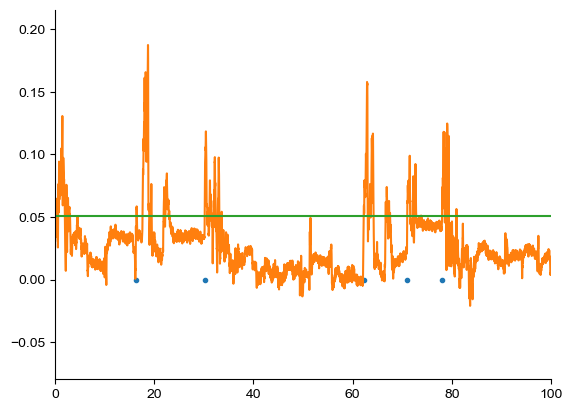

In [26]:

plt.plot([t/1000 for t in trig_ms], [0 for _ in range(len(trig_ms))],'.')
plt.plot([t/1000 for t in photometry_times_pyc], [v - mn for v in analog_2_bp],'-')
plt.plot([np.nanmin(photometry_times_pyc)/1000, np.nanmax(photometry_times_pyc)/1000], [2*sd, 2*sd],'-')

plt.xlim(0,100)
plt.show()

In [27]:

def get_waveform_average(signal, window_before_ms, window_after_ms, trig_ind):

    # Example time series data and events
    # signal = analog_1_bp

    # Define the window around events to compute the average waveform
    # window_before_ms = 1000 * 3
    # window_after_ms = 1000 * 3

    # Initialize an empty array to store the waveform segments
    waveform_segments = []

    # Extract waveform segments around each event index
    for event_index in trig_ind:
        start_index = event_index - window_before_ms
        end_index = event_index + window_after_ms + 1
        segment = signal[start_index:end_index]
        waveform_segments.append(segment)

    # Stack the waveform segments and compute the average along the first axis
    waveform_segments = np.stack(waveform_segments)
    waveform_average = np.mean(waveform_segments, axis=0)
    waveform_std = np.std(waveform_segments, axis=0)
    waveform_sem = waveform_std / np.sqrt(waveform_segments.shape[0] )
    sample_size = waveform_segments.shape[0]
    # print("Waveform average:", waveform_average)

    return waveform_segments, waveform_average, waveform_std, waveform_sem, sample_size



In [28]:
window_before_ms = 1000 * 3
window_after_ms = 1000 * 4

keys = ['waveform_segments', 'waveform_average', 'waveform_std', 'waveform_sem', 'sample_size']

wa_analog_1_bp = dict(zip(keys, get_waveform_average(analog_1_bp, window_before_ms, window_after_ms, trig_ind)))
wa_analog_2_bp = dict(zip(keys, get_waveform_average(analog_2_bp, window_before_ms, window_after_ms, trig_ind)))

wa_analog_1_est_motion = dict(zip(keys, get_waveform_average(analog_1_est_motion, window_before_ms, window_after_ms, trig_ind)))
wa_analog_1_corrected = dict(zip(keys, get_waveform_average(analog_1_corrected, window_before_ms, window_after_ms, trig_ind)))

wa_analog_1_est_motion_bp = dict(zip(keys, get_waveform_average(analog_1_est_motion_bp, window_before_ms, window_after_ms, trig_ind)))

analog_1_corrected_bp = analog_1_bp - analog_1_est_motion_bp #TODO is this correct

wa_analog_1_corrected_bp = dict(zip(keys, get_waveform_average(analog_1_corrected_bp, window_before_ms, window_after_ms, trig_ind)))


In [29]:
analog_1_bp.shape

(3605950,)

In [30]:
analog_1_est_motion_bp.shape

(3605950,)

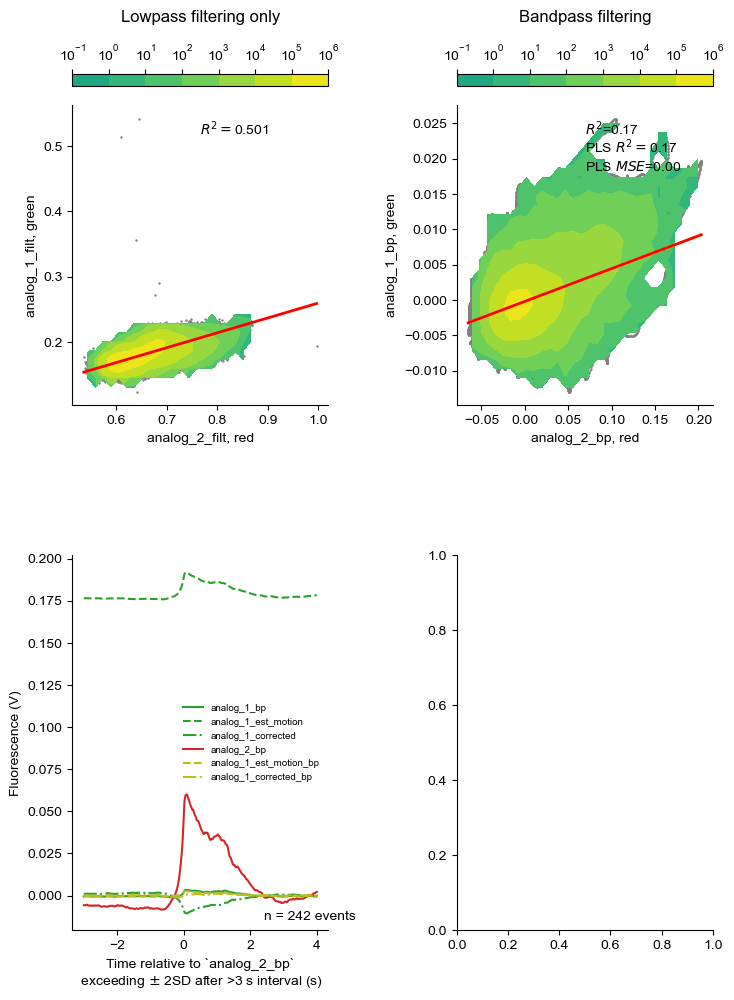

In [31]:
T_vec = np.linspace(-1 * window_before_ms , window_after_ms, len(wa_analog_1_bp['waveform_average']))/1000


i = 1
j = 0
plt.sca(ax[i, j])

plt.cla()

plt.plot(T_vec, wa_analog_1_bp['waveform_average'], label='analog_1_bp', color='#2ca02c', ls = '-')
plt.plot(T_vec, wa_analog_1_est_motion['waveform_average'], label='analog_1_est_motion', color='#2ca02c', ls='--')
plt.plot(T_vec, wa_analog_1_corrected['waveform_average'], label='analog_1_corrected', color='#2ca02c', ls='-.')

plt.plot(T_vec, wa_analog_2_bp['waveform_average'], label='analog_2_bp', color='#d62728', ls = '-')

plt.plot(T_vec, wa_analog_1_est_motion_bp['waveform_average'],
         label='analog_1_est_motion_bp', color='#bcbd22', ls='--')
plt.plot(T_vec, wa_analog_1_corrected_bp['waveform_average'],
         label='analog_1_corrected_bp', color='#bcbd22', ls='-.')


plt.xlabel('Time relative to `analog_2_bp`\n exceeding $\pm$ 2SD after >3 s interval (s)')
plt.ylabel('Fluorescence (V)')

plt.gca().legend(loc='upper left', frameon=False)

plt.text(0.75, 0.03, f"n = {wa_analog_1_bp['sample_size']:d} events", transform=plt.gca().transAxes)
plt.gca().legend(loc='right', frameon=False, fontsize=7)
plt.show()


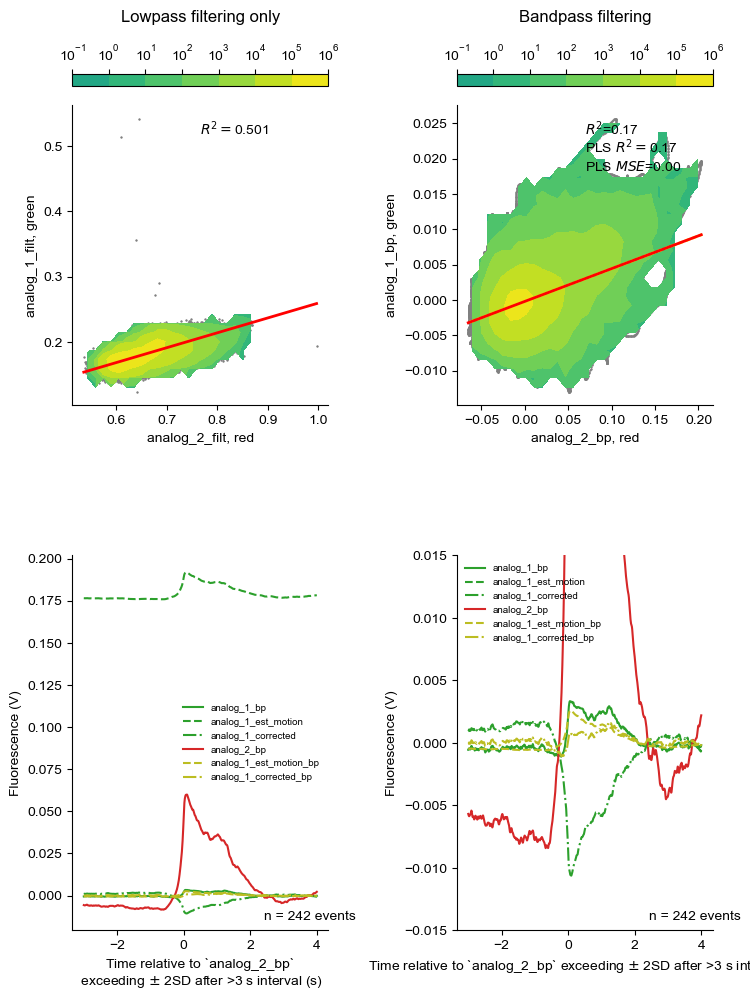

In [32]:
i = 1
j = 1
plt.sca(ax[i, j])

plt.cla()

plt.plot(T_vec, wa_analog_1_bp['waveform_average'],
         label='analog_1_bp', color='#2ca02c', ls='-')
plt.plot(T_vec, wa_analog_1_est_motion['waveform_average'],
         label='analog_1_est_motion', color='#2ca02c', ls='--')
plt.plot(T_vec, wa_analog_1_corrected['waveform_average'],
         label='analog_1_corrected', color='#2ca02c', ls='-.')

plt.plot(T_vec, wa_analog_2_bp['waveform_average'],
         label='analog_2_bp', color='#d62728', ls='-')

plt.plot(T_vec, wa_analog_1_est_motion_bp['waveform_average'],
         label='analog_1_est_motion_bp', color='#bcbd22', ls='--')
plt.plot(T_vec, wa_analog_1_corrected_bp['waveform_average'],
         label='analog_1_corrected_bp', color='#bcbd22', ls='-.')


plt.xlabel(
    'Time relative to `analog_2_bp` exceeding $\pm$ 2SD after >3 s interval (s)')
plt.ylabel('Fluorescence (V)')

plt.text(0.75, 0.03, f"n = {wa_analog_1_bp['sample_size']:d} events", transform=plt.gca().transAxes)

plt.gca().legend(loc='upper left', frameon=False, fontsize=7)

plt.ylim(-0.015, 0.015)
plt.show()

Even though the effect is pretty small and negligble, the current method of motion correction is clearly injecting the negative artefacts to the data (`analong_1_corrected`).

Linear regression after the bandpass filtering is outperforming the current method. `analog_1_est_motion_bp` is more akin to the level of putative aretefacts in `analog1_bp`, and after correction, the peak of artefact is smaller though it is not completely flat (`analog_1_corrected_bp`)

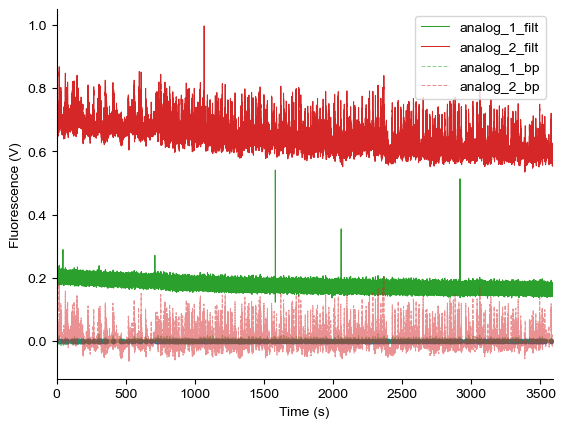

In [33]:


plt.figure()

plt.plot([t/1000 for t in trig_ms], [0 for _ in range(len(trig_ms))],'.')
plt.plot([t/1000 for t in photometry_times_pyc], [v - mn for v in analog_1_filt],'-', label='analog_1_filt', color='#2ca02c', linewidth=0.75)
plt.plot([t/1000 for t in photometry_times_pyc], [v - mn for v in analog_2_filt],'-', label='analog_2_filt', color='#d62728',linewidth=0.75)
plt.plot([t/1000 for t in photometry_times_pyc], [v - mn for v in analog_1_bp],'--', label='analog_1_bp', color='#2ca02c',linewidth=0.75, alpha=0.5)
plt.plot([t/1000 for t in photometry_times_pyc], [v - mn for v in analog_2_bp],'--', label='analog_2_bp', color='#d62728',linewidth=0.75, alpha=0.5)

plt.xlim(np.nanmin(photometry_times_pyc)/1000, np.nanmax(photometry_times_pyc)/1000)
plt.legend(loc='upper right')
plt.ylabel('Fluorescence (V)')
plt.xlabel('Time (s)')
plt.show()


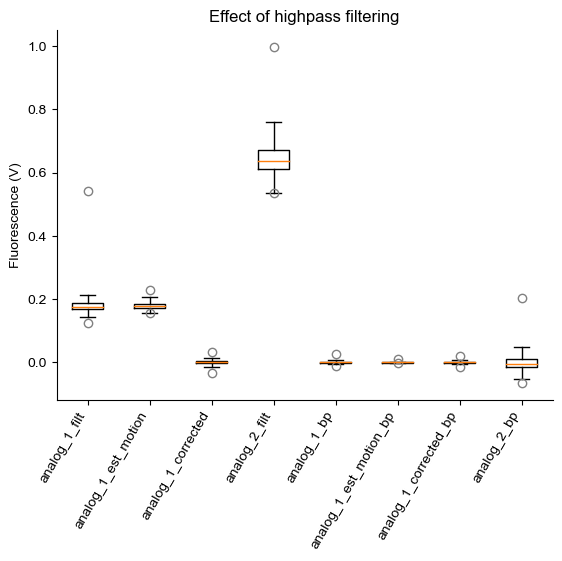

In [34]:
data = [analog_1_filt, analog_1_est_motion, analog_1_corrected, analog_2_filt , analog_1_bp, analog_1_est_motion_bp, analog_1_corrected_bp, analog_2_bp]

plt.figure()

bx = plt.boxplot(data, showfliers=False) # too many outliers

for i in range(0, 8):
    plt.plot(i+1, np.nanmax(data[i]), 'o', markerfacecolor='none', color=[0.5, 0.5, 0.5])
    plt.plot(i+1, np.nanmin(data[i]), 'o', markerfacecolor='none', color=[0.5, 0.5, 0.5])

plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['analog_1_filt','analog_1_est_motion', 'analog_1_corrected',  'analog_2_filt',
                           'analog_1_bp', 'analog_1_est_motion_bp', 'analog_1_corrected_bp', 'analog_2_bp'])
plt.xticks(rotation = 60, ha = 'right')

#[L.set_alpha(0.2) for L in bx['fliers']]
plt.ylabel('Fluorescence (V)')
plt.title('Effect of highpass filtering')

plt.show()


# $$\frac{\Delta F} {F}$$

Thomas Akam's way

https://github.com/ThomasAkam/photometry_preprocessing/blob/master/Photometry%20data%20preprocessing.ipynb

> To compute dF/F we divide the signal changes (dF) by the baseline fluorescence (F) and multiply by 100 to convert to percent. The dF is just the motion corrected signal plotted above. The baseline fluorescence F changes over the course of the session due to photobleaching, and is just the baseline we estimated with our double exponential fit.

$$\frac{\Delta F}{F} = \frac{Signal}{Filtered\_Signal}$$


```python
b,a = butter(2, low_pass_cutoff, btype='low', fs=photometry_dict['sampling_rate'])
photometry_dict['analog_1_baseline_fluo'] = filtfilt(b,a, photometry_dict['analog_1_filt'], padtype='even')

# Now calculate the dF/F by dividing the motion corrected signal by the time varying baseline fluorescence.
photometry_dict['analog_1_df_over_f'] = photometry_dict['analog_1_corrected'] / photometry_dict['analog_1_baseline_fluo']
```


However, $$\frac{\Delta F}{F} = \frac{Signal - Fitted\_Control}{Fitted\_Control}$$ seems more common practice, using different wavelength of light for the same fluorphore.

> In either case, after a control channel is established, a fitted control channel is obtained by fitting the control channel to signal channel using a least squares polynomial fit of degree 1. ΔF/F is computed by subtracting the fitted control channel from the signal channel, and dividing by the fitted control channel: Sherathiya VN, Schaid MD, Seiler JL, Lopez GC, Lerner TN (2021) GuPPy, a Python toolbox for the analysis of fiber photometry data. Sci Rep 11:24212, https://doi.org/10.1038/s41598-021-03626-9

On (GitHub)[https://github.com/ThomasAkam/photometry_preprocessing/issues/1], Thomas Akam is saying that the reason for the choice of his method is because he is using different fluorescent reporter (tdTomato) rather than using isobestic light.

> Using a linear fit of the control signal as the baseline to compute df/f assumes that bleaching occurs in the control signal with the same timecourse as in the main signal. This may be a reasonable assumption when using isosbestic illumination of the reporter flurophore as the control channel, but in our data where we use a seperate red flurophore (e.g. TdTomato) as the control channel we typically do not see bleaching in the control channel to the same extent or with the same timecourse as in the main channel. Even when using isosbestic illumination as the control channel there is no guarantee that bleaching in the control channel will have the same timecourse as that in the main channel.
